In [1]:
import sys
sys.path.append('../../SABR')
sys.path.append('../../heston')
sys.path.append('../../heston/heston calibration/')

from SABR_montecarlo import *
from sabr_approx import *

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from double_heston_calibration import *
from heston_calibration import *
from heston_derivatives import *
from heston import *

In [3]:
def gen_random_heston_params():
    v0 = np.random.rand(1) * 0.015 + 0.01
    theta = np.random.rand(1) * 0.015 + 0.01
    
    rho = -0.9 + (1.8) * np.random.rand(1)
    k = np.random.rand(1) * 2 + 1.0
    sig = np.random.rand(1) * 0.002 + 0.01
    
    return v0[0], theta[0], rho[0], k[0], sig[0]

In [4]:
v0_0    = 0.175
theta_0 = 0.02
rho_0   = 0.5
k_0     = 2.0
sig_0   = 0.5

heston_params_0 = np.asarray( [v0_0, theta_0, rho_0, k_0, sig_0] )

r = 0.1

In [5]:
S0 = 1.0
K0 = 1.0
T = 1.0

Nk = 15
Kn = K0 * (1 + np.linspace(-0.5, 0.5, Nk))

Nt = 5
Tn = np.linspace(T / 5, T * 2, Nt)

In [6]:
Nu = 50

In [7]:
C0, IV0 = getVolatilitySurface(S0, Kn, Tn, Nu, r, *heston_params_0)

In [8]:
X, Y = np.meshgrid(Tn, Kn)

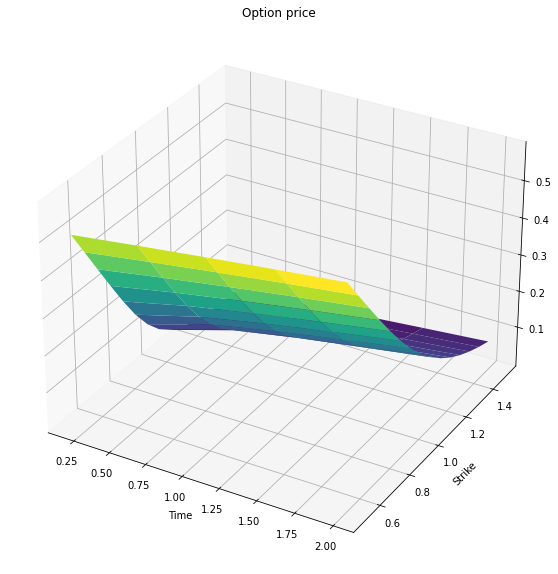

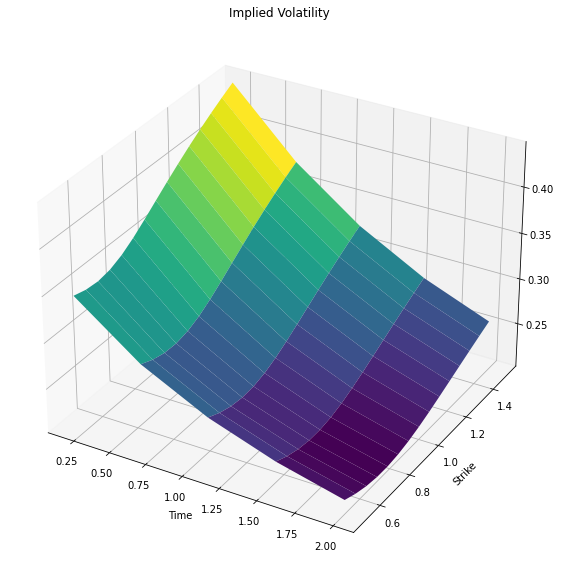

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, C0, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Option price')
plt.xlabel("Time")
plt.ylabel("Strike")
None

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, IV0, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Implied Volatility')
plt.xlabel("Time")
plt.ylabel("Strike")
None

# Optimization

In [10]:
w = 1 / (0.1 + np.abs(Kn - S0) ** 2)
weights = [w[:] for _ in range(len(Tn))]

In [11]:
list(gen_random_heston_params())

[0.018210764476390452,
 0.018316790301765133,
 0.6085338685643787,
 2.855661109302696,
 0.01095798861187604]

In [12]:
Ndim = 2

params = []

for _ in range(Ndim):
    params += list(gen_random_heston_params())
heston_params = np.asarray(params)

In [13]:
Niter = 1000

In [14]:
f = lambda _z: getResudalAndGradDouble(C0, S0, Kn, Tn, Nu, r, weights, _z)
proj = my_clip

heston_params, fs = MyAlgorithm(Niter, f, proj, heston_params)

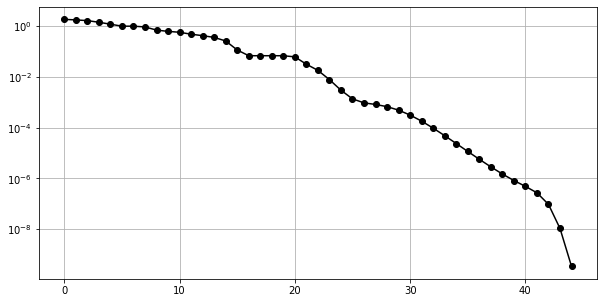

In [15]:
plt.figure(figsize=(10, 5))
plt.semilogy(fs, '-ok')
plt.grid()

# Sabr Calibration

In [16]:
alpha_sabr = 0.15
beta_sabr = 0.25
rho_sabr = -0.25

sig0_sabr = 0.3

In [17]:
Csabr = np.zeros((Nk, Nt))
IVsabr = np.zeros_like(Csabr)

tn = np.linspace(0, 1, 20)
Npaths = 10000

for t in range(Nt):
    
    F0 = S0 * np.exp(r * Tn[t])
    
    F = SabrEulerModified(F0, sig0_sabr, Npaths, tn * Tn[t], alpha_sabr, beta_sabr, rho_sabr)
    F = F - np.mean(F) + F0
    payoff = np.exp(-r * Tn[t]) * np.maximum(F.reshape(-1, 1) - Kn.reshape(1, -1), 0.0)
    C = np.mean(payoff, axis=0)
    Csabr[:, t] = C.reshape(-1) 
    
    IVsabr[:, t] = getIV(C.reshape(-1), Kn.reshape(-1), S0, r, Tn[t])

In [18]:
w = np.ones_like(Kn)
w = 1 / (0.1 + np.abs(Kn - S0) ** 2 )
weights = [w[:] for _ in range(len(Tn))]

In [19]:
Niter = 150

In [20]:
Ndim = 4

params = []

for _ in range(Ndim):
    params += list(gen_random_heston_params())
heston_params = np.asarray(params) / Ndim


In [21]:
f = lambda _z: getResudalAndGradDouble(Csabr, S0, Kn, Tn, Nu, r, weights, _z)
proj = my_clip

heston_params, fs = MyAlgorithm(Niter, f, proj, heston_params)

In [22]:
fs[-1]

0.01628215049902481

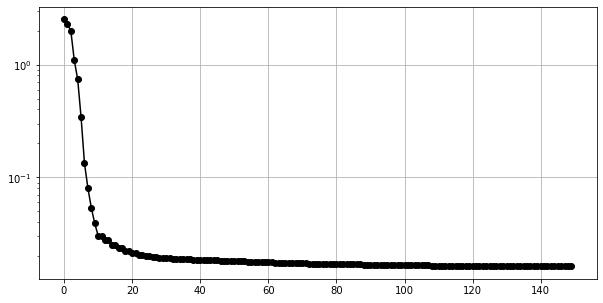

In [23]:
plt.figure(figsize=(10, 5))
plt.semilogy(fs, '-ok')
plt.grid()

In [24]:
C_calibrated, IV_calibrated = getVolatilitySurfaceDouble(S0, Kn, Tn, Nu, r, heston_params)

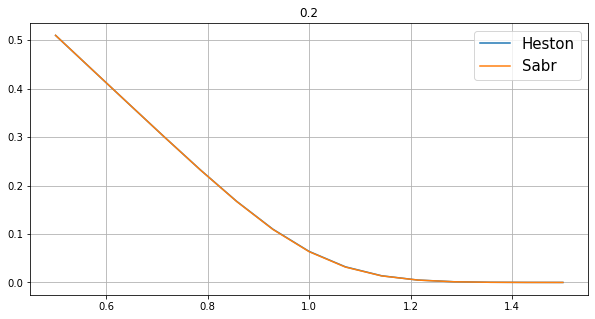

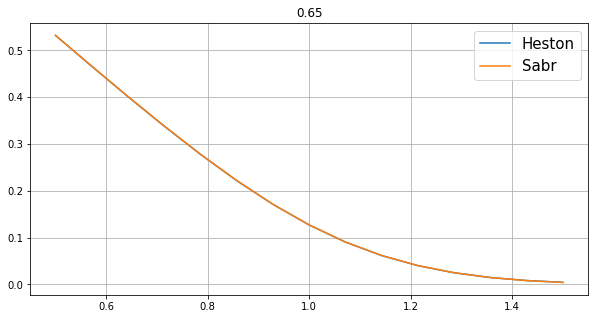

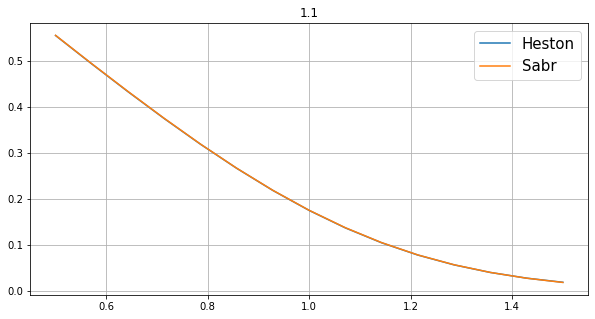

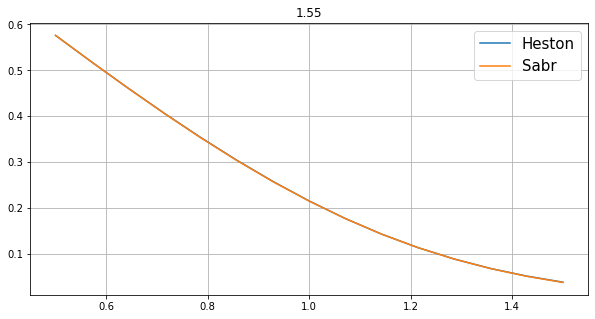

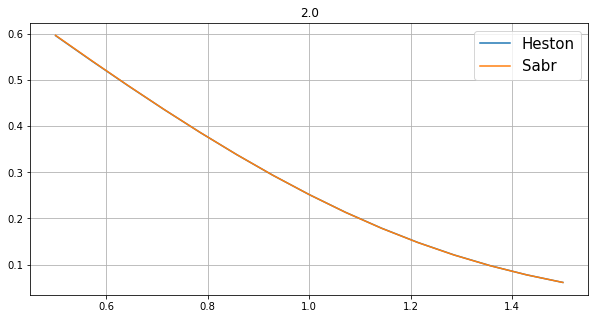

In [25]:
for t in range(Nt):
    plt.figure(figsize=(10, 5))
    plt.plot(Kn, C_calibrated[:, t], label='Heston')
    plt.plot(Kn, Csabr[:, t], label='Sabr')
    plt.title(Tn[t])
    plt.legend(fontsize=15)
    plt.grid()

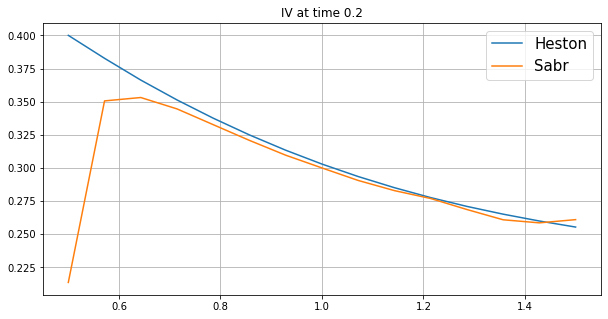

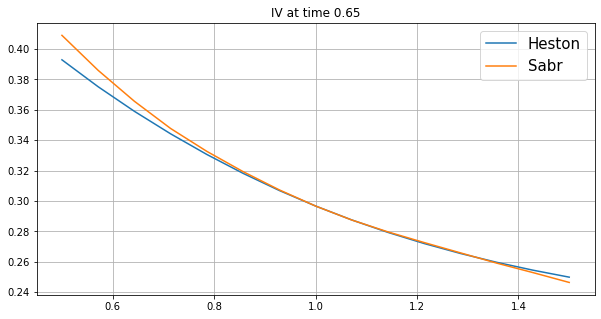

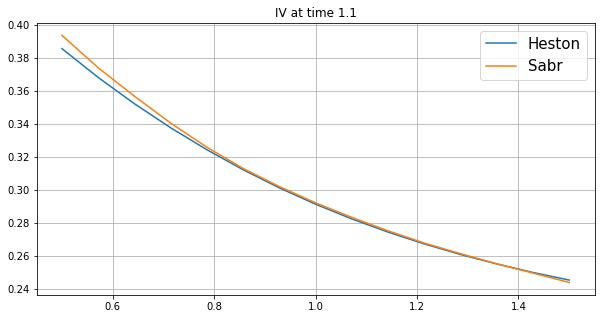

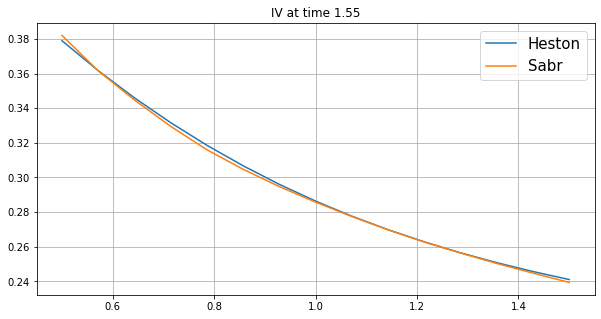

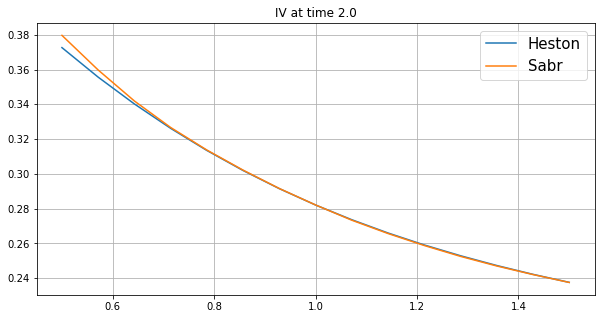

In [26]:
for t in range(Nt):
    plt.figure(figsize=(10, 5))
    plt.plot(Kn, IV_calibrated[:, t], label='Heston')
    plt.plot(Kn, IVsabr[:, t], label='Sabr')
    plt.title(f'IV at time {Tn[t]}')
    plt.legend(fontsize=15)
    plt.grid()